# Imports

In [3]:
from torchaudio.models.decoder import download_pretrained_files
from torchaudio.models.decoder import ctc_decoder
import torch.optim.lr_scheduler as lr_scheduler
from pytorch_model_summary import summary
from torch.nn import functional as F
from torch.utils.data import Dataset
import torchaudio.functional as AF
from torch import optim
import torch.nn as nn
import torchaudio
import torch

from datasets import load_dataset
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer, cer
from typing import List
import numpy as np
import glob
import os

/home/nathanmon/.local/lib/python3.10/site-packages/torchaudio/models/decoder/_ctc_decoder.py:62: UserWarning: The built-in flashlight integration is deprecated, and will be removed in future release. Please install flashlight-text. https://pypi.org/project/flashlight-text/ For the detail of CTC decoder migration, please see https://github.com/pytorch/audio/issues/3088.
  warnings.warn(


In [4]:
device = "cuda"

# Get Data

In [24]:
my_speech_files = glob.glob("/media/nathanmon/389E28739E282BB6/Users/Natha/Datasets/MySpeechData/my_voice/*")
other_speech_files = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test")['path']
music_files = glob.glob("/home/nathanmon/Artificial Intelligence/PyTorch/Audio Recognition/Voice Classification/batches/*")
other_speech_files = other_speech_files[:len(my_speech_files)-len(music_files)]

positive_labels = np.ones(len(my_speech_files))
negative_labels = np.zeros(len(my_speech_files))

speech_files = np.concatenate((my_speech_files, other_speech_files, music_files))
labels = np.concatenate((positive_labels, negative_labels))

combined = list(zip(speech_files, labels))
for i in range(5):
    np.random.shuffle(combined)

speech_files, labels = zip(*combined)

In [26]:
# sample_rate = 8000
# max_length = 85000

# count = 0
# for i, file in enumerate(my_speech_files):
#     wav, sr = torchaudio.load(file)
#     wav = AF.resample(wav, sr, sample_rate)
    
#     if len(wav[0]) > 85000:
#         count += 1
# print(count)

In [27]:
# An integer scalar Tensor. The window length in samples.
n_mels = 128
# An integer scalar Tensor. The number of samples to step.
win_length = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
hop_length = 80

def add_noise(waveform, noise_level=0.005):
    # Generate random noise with the same length as the waveform
    noise = torch.randn_like(waveform) * noise_level
    
    # Add the noise to the waveform
    noisy_waveform = waveform + noise
    
    return noisy_waveform

def load_wav(filename):
    wav, sr = torchaudio.load(filename)
    wav = AF.resample(wav, sr, sample_rate)
    if len(wav[0]) < max_length:
        wav = torch.concat((wav[0], torch.zeros(max_length - len(wav[0])))).unsqueeze(-2)
    else:
        cut_length = len(wav[0]) - max_length
        wav = wav[0][cut_length//2:len(wav[0])-(cut_length//2)].unsqueeze(-2)
        
    noise = np.random.normal(0, 1, max_length)
    wav = torchaudio.transforms.Vol(gain=torch.rand(1)/2, gain_type="amplitude")(wav)
    wav = add_noise(wav, noise_level=0.02)
    return wav, sr

def create_spect(wav, sr, freq_mask=15, time_mask=35):
    spect = torchaudio.transforms.MelSpectrogram(
                                    sample_rate=sr, n_mels=n_mels,
                                    win_length=win_length, 
                                    hop_length=hop_length
    )(wav)
    spect = nn.Sequential(
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask),
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask),
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask),
#             torchaudio.transforms.TimeStretch(fixed_rate=0.5)
    )(spect)
    spect = np.log(spect + 1e-14)
    
    return spect

def encode_sample(file, label):
    wav, sr = load_wav(file)
    spect = create_spect(wav, sr)
        
    return spect, label

In [28]:
sr

32000

Speech file: 
 /home/nathanmon/.cache/huggingface/datasets/downloads/extracted/75978be2735cfea643f2e95ccce48820580b6d530ecc8b0d60550460c936fd30/en_test_0/common_voice_en_27710027.mp3
Sample rate: 
 32000

Shape: 
 torch.Size([128, 1063])



(-0.5, 1062.5, 127.5, -0.5)

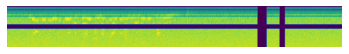

In [29]:
index = 0
file = other_speech_files[index]
print("Speech file: \n", file)

ex_wav, sr = load_wav(file)
ex_spect = create_spect(ex_wav, sr)[0]
print("Sample rate: \n", sr)
print("\nShape: \n", ex_spect.shape)
print()

ax = plt.subplot(1, 1, 1)
ax.imshow(ex_spect, vmax=1)
ax.axis("off")

In [30]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, speech_files, labels, 
                 batch_size=16, max_length=150):
        self.filenames = speech_files
        self.labels = labels
        self.batch_size = batch_size
        self.max_length = max_length

    def __len__(self):
        return len(self.filenames)

    def getitem(self, idx):
        spects, labels = [], []
        start_idx = idx*self.batch_size
        for filename, label in zip(self.filenames[start_idx:start_idx+batch_size],
                                   self.labels[start_idx:start_idx+batch_size]):
            spect, label = encode_sample(filename, label)
            spects.append(torch.tensor(spect, dtype=torch.float32))
                
            labels.append(label)

        spects = torch.cat(spects, dim=0)
        labels = torch.tensor(labels)
        return spects, labels

In [31]:
batch_size = 16
dataloader = MelSpectrogramDataset(speech_files, labels, batch_size=batch_size)

In [32]:
dataloader.getitem(0)[0].shape

/tmp/ipykernel_970623/2983822708.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spects.append(torch.tensor(spect, dtype=torch.float32))


torch.Size([16, 128, 1063])

In [33]:
dataloader.getitem(0)[1]

/tmp/ipykernel_970623/2983822708.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spects.append(torch.tensor(spect, dtype=torch.float32))


tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.],
       dtype=torch.float64)

# Build Model

In [34]:
class ActDropNormCNN1D(nn.Module):
    def __init__(self, n_feats, dropout, keep_shape=False):
        super(ActDropNormCNN1D, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(n_feats)
        self.keep_shape = keep_shape
    
    def forward(self, x):
        x = x.transpose(1, 2)
        # x = self.norm(self.dropout(F.gelu(x)))
        x = self.dropout(F.gelu(self.norm(x)))
        if self.keep_shape:
            return x.transpose(1, 2)
        else:
            return x


class VoiceEntityClassification(nn.Module):
    def __init__(self, hidden_size, num_classes, n_feats, num_layers, dropout):
        super(VoiceEntityClassification, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.cnn1 = nn.Sequential(
            nn.Conv1d(n_feats, n_feats, 10, 2, padding=10//2),
            ActDropNormCNN1D(n_feats, dropout, keep_shape=True),
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(n_feats, n_feats, 10, 2, padding=10//2),
            ActDropNormCNN1D(n_feats, dropout),
        )
        self.dense = nn.Sequential(
            nn.Linear(n_feats*267, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        
        self.layer_norm2 = nn.LayerNorm(128)
        self.dropout2 = nn.Dropout(dropout)
        self.final_fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def _init_hidden(self, batch_size):
        n, hs = self.num_layers, self.hidden_size
        return (torch.zeros(n*1, batch_size, hs).to(device),
                torch.zeros(n*1, batch_size, hs).to(device))

    def forward(self, x, hidden):
        x = x.to(device)
        x = self.cnn1(x) # batch, channels, time, feature
        x = self.cnn2(x)
        x = torch.flatten(x, 1)
        x = self.dense(x) # batch, time, feature
        x = self.dropout2(F.gelu(self.layer_norm2(x)))  # (time, batch, n_class)
        return self.final_fc(x)

In [35]:
d_model = 128

speech_model = VoiceEntityClassification(hidden_size=d_model,
                                         num_classes=len(characters),
                                         n_feats=128,
                                         num_layers=1,
                                         dropout=0.5).to(device)

In [36]:
print(summary(speech_model, torch.unsqueeze(dataloader.getitem(0)[0][0], 0), 
              speech_model._init_hidden(1), show_input=True))

/tmp/ipykernel_970623/2983822708.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spects.append(torch.tensor(spect, dtype=torch.float32))


--------------------------------------------------------------------------
         Layer (type)         Input Shape         Param #     Tr. Param #
             Conv1d-1      [1, 128, 1063]         163,968         163,968
   ActDropNormCNN1D-2       [1, 128, 532]             256             256
             Conv1d-3       [1, 128, 532]         163,968         163,968
   ActDropNormCNN1D-4       [1, 128, 267]             256             256
             Linear-5          [1, 34176]       4,374,656       4,374,656
          LayerNorm-6            [1, 128]             256             256
               GELU-7            [1, 128]               0               0
            Dropout-8            [1, 128]               0               0
             Linear-9            [1, 128]          16,512          16,512
         LayerNorm-10            [1, 128]             256             256
              GELU-11            [1, 128]               0               0
           Dropout-12            [1, 

In [47]:
def train_epoch(dataloader, model, optimizer, criterion, train=True):
    global batch_size
    total_loss = 0
    for batch in range(len(dataloader) // batch_size):
        spects, labels = dataloader.getitem(batch)
        labels = labels.unsqueeze(1)
        
        optimizer.zero_grad()
        
        print(spects.shape)
        nigga
        hidden = model._init_hidden(batch_size)
        logits = model(torch.tensor(spects), hidden)
        loss = criterion(logits.to(torch.double), labels.to(torch.double).to(device))
        
        if train:
            loss.backward()

            optimizer.step()
    
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [48]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [49]:
class CustomSchedule(object):
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        super().__init__()

        self.optimizer = optimizer
        self.d_model = float(d_model)

        self.warmup_steps = warmup_steps
        
        self.iters = 0.0

    def step(self):
        self.iters += 1.0
        arg1 = 1 / math.sqrt(self.iters)
        arg2 = self.iters * (self.warmup_steps ** -1.5)
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = 1 / math.sqrt(self.d_model) * min(arg1, arg2)

In [50]:
plot_train_losses = []
plot_val_losses = []

def train(train_dataloader, val_dataloader, model, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    global plot_train_losses
    global plot_val_losses
    global d_model
    print_train_loss_total = 0  # Reset every print_every
    plot_train_loss_total = 0  # Reset every plot_every
    
    print_val_loss_total = 0  # Reset every print_every
    plot_val_loss_total = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.BCEWithLogitsLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                                optimizer, mode='min',
                                factor=0.50, patience=6)
    
    for epoch in range(1, n_epochs + 1):
        train_loss = train_epoch(train_dataloader, model, optimizer, criterion)
        print_train_loss_total += train_loss
        plot_train_loss_total += train_loss
        
        # Evaluate validation dataloader
        val_loss = train_epoch(val_dataloader, model, optimizer, criterion, train=False)
        print_val_loss_total += val_loss
        plot_val_loss_total += val_loss
        
        scheduler.step(val_loss)

        if epoch % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print_val_loss_avg = print_val_loss_total / print_every
            print_val_loss_total = 0
            print('%s (%d %d%%) %.4f %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_train_loss_avg, print_val_loss_avg
                                             ))
            print()

        if epoch % plot_every == 0:
            plot_train_loss_avg = plot_train_loss_total / plot_every
            plot_train_losses.append(plot_train_loss_avg)
            plot_train_loss_total = 0
            
            plot_val_loss_avg = plot_val_loss_total / plot_every
            plot_val_losses.append(plot_val_loss_avg)
            plot_val_loss_total = 0

    showPlot(plot_train_losses)
    showPlot(plot_val_losses)

In [51]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [52]:
batch_size = 32
train_dataloader = MelSpectrogramDataset(speech_files[:4000], labels[:4000], 
                                   batch_size=batch_size)
val_dataloader = MelSpectrogramDataset(speech_files[4000:], labels[4000:], 
                                   batch_size=batch_size)

train(train_dataloader, val_dataloader, speech_model, 15, 
      learning_rate=1e-3, print_every=5, plot_every=5)

/tmp/ipykernel_970623/2983822708.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spects.append(torch.tensor(spect, dtype=torch.float32))


torch.Size([32, 128, 1063])


NameError: name 'nigga' is not defined

In [44]:
torch.save(speech_model, "my_voice.pth")

In [ ]:
index = 1000
file = my_speech_files[index]
print("Speech file: \n", file)

ex_wav, sr = load_wav(file)
ex_spect = create_spect(ex_wav, sr)[0]
print("Sample rate: \n", sr)
print("\nShape: \n", ex_spect.shape)
print()

ax = plt.subplot(1, 1, 1)
ax.imshow(ex_spect, vmax=1)
ax.axis("off")

In [ ]:
out = speech_model(torch.unsqueeze(ex_spect, 0), speech_model._init_hidden(1))
sigmoid = nn.Sigmoid()
out = sigmoid(out)
out